Import files

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# path to file you will use for predictions
train_data_path = '../input/trip-fare/train.csv'
train_data = pd.read_csv(train_data_path)

test_data_path = '../input/trip-fare/test.csv'
test_data = pd.read_csv(test_data_path)


In [2]:
train_data['labels'] = 0

for index, row in train_data.iterrows():
    if(row['label'] == "correct" ):
        train_data.at[index, 'labels'] = 1
train_data.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,labels
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct,1
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct,1
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct,1
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct,1
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct,1


Creating new feature trip_time by taking the difference between drop_time and pickup_time

In [3]:
import datetime
# convert to date time format and invalid to NaT
train_data['drop_time'] = pd.to_datetime(train_data['drop_time'], errors='coerce')
train_data['pickup_time'] = pd.to_datetime(train_data['pickup_time'], errors='coerce')
test_data['drop_time'] = pd.to_datetime(test_data['drop_time'], errors='coerce')
test_data['pickup_time'] = pd.to_datetime(test_data['pickup_time'], errors='coerce')

# make a new column in dataframes including the difference 
train_data['trip_time'] = train_data.drop_time - train_data.pickup_time
test_data['trip_time'] = test_data.drop_time - test_data.pickup_time

# convert date time to float64 format
train_data['trip_time'] = train_data['trip_time'].dt.total_seconds()
test_data['trip_time'] = test_data['trip_time'].dt.total_seconds()
# train_data['drop_time_seconds'] = (train_data['drop_time']-datetime.datetime(1970,1,1)).dt.total_seconds()
# train_data['pickup_time_seconds'] = (train_data['pickup_time']-datetime.datetime(1970,1,1)).dt.total_seconds()
# test_data['drop_time_seconds'] = (train_data['drop_time']-datetime.datetime(1970,1,1)).dt.total_seconds()
# test_data['pickup_time_seconds'] = (train_data['pickup_time']-datetime.datetime(1970,1,1)).dt.total_seconds()
train_data.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,labels,trip_time
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,correct,1,840.0
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,correct,1,780.0
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,correct,1,1080.0
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,correct,1,600.0
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,correct,1,1020.0


Distance calculation function using given longitude and latitude

In [4]:
import numpy as np # linear algebra
import math as math_stl

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371000  # m
    dlat = math_stl.radians(lat2 - lat1)
    dlon = math_stl.radians(lon2 - lon1)
    a = math_stl.sin(dlat / 2) * math_stl.sin(dlat / 2) + math_stl.cos(math_stl.radians(lat1)) * math_stl.cos(math_stl.radians(lat2)) * math_stl.sin(dlon / 2) * math_stl.sin(dlon / 2)
    c = 2 * math_stl.atan2(math_stl.sqrt(a), math_stl.sqrt(1 - a))
    d = radius * c
    return d

Add new travel distance column 

In [5]:
train_data['distance'] = 0.0
test_data['distance'] = 0.0

for index, row in train_data.iterrows():
    train_data.at[index, 'distance'] = haversine_distance(row['pick_lat'], row['pick_lon'], row['drop_lat'], row['drop_lon'])

for index, row in test_data.iterrows():
    test_data.at[index, 'distance'] = haversine_distance(row['pick_lat'], row['pick_lon'], row['drop_lat'], row['drop_lon'])
    
train_data.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,labels,trip_time,distance
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,correct,1,840.0,5092.769919
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,correct,1,780.0,3168.057584
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,correct,1,1080.0,6305.395096
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,correct,1,600.0,861.946120
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,correct,1,1020.0,8147.782201


Fare zero feature adding

In [6]:
train_data['fare_zero'] = 0
test_data['fare_zero'] = 0

# train_data['fare'] = train_data['fare'].fillna(0)
# test_data['fare'] = test_data['fare'].fillna(0)

for index, row in train_data.iterrows():
    if(row['fare'] == 0 ):
        train_data.at[index, 'fare_zero'] = 1
        
for index, row in test_data.iterrows():
    if(row['fare'] == 0):
        test_data.at[index, 'fare_zero'] = 1
train_data.head()


,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,labels,trip_time,distance,fare_zero
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,correct,1,840.0,5092.769919,0
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,correct,1,780.0,3168.057584,0
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,correct,1,1080.0,6305.395096,0
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,correct,1,600.0,861.946120,0
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,correct,1,1020.0,8147.782201,0


Creating the features list

In [7]:
train_data['total_add_fare'] = 0.0
test_data['total_add_fare'] = 0.0

train_data['a_f'] = train_data['additional_fare'].fillna(0)
train_data['m_w_f'] = train_data['meter_waiting_fare'].fillna(0)
test_data['a_f'] = test_data['additional_fare'].fillna(0)
test_data['m_w_f'] = test_data['meter_waiting_fare'].fillna(0)


for index, row in train_data.iterrows():
    train_data.at[index, 'total_add_fare'] = row['a_f'] + row['m_w_f']
        
for index, row in test_data.iterrows():
    test_data.at[index, 'total_add_fare'] = row['a_f'] + row['m_w_f']
train_data.head()


,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,drop_lon,fare,label,labels,trip_time,distance,fare_zero,total_add_fare,a_f,m_w_f
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,...,79.8783,270.32,correct,1,840.0,5092.769919,0,10.5000,10.5,0.0000
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,...,79.8923,197.85,correct,1,780.0,3168.057584,0,10.5000,10.5,0.0000
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,...,79.9146,301.64,correct,1,1080.0,6305.395096,0,10.5000,10.5,0.0000
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,...,79.8971,82.30,correct,1,600.0,861.946120,0,26.1638,10.5,15.6638
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,...,79.9290,358.39,correct,1,1020.0,8147.782201,0,0.0000,0.0,0.0000


(fare - waiting_fare) / distance

In [8]:
train_data['fare_per_m'] = 0.0
test_data['fare_per_m'] = 0.0

train_data['f'] = train_data['fare'].fillna(0)
test_data['f'] = test_data['fare'].fillna(0)


for index, row in train_data.iterrows():
    if (row['distance'] == 0):
        continue
    train_data.at[index, 'fare_per_m'] = (row['f'] - row['m_w_f']) / row['distance']
        
for index, row in test_data.iterrows():
    if (row['distance'] == 0):
        continue
    test_data.at[index, 'fare_per_m'] = (row['f'] - row['m_w_f']) / row['distance']
train_data.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,label,labels,trip_time,distance,fare_zero,total_add_fare,a_f,m_w_f,fare_per_m,f
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,...,correct,1,840.0,5092.769919,0,10.5000,10.5,0.0000,0.053079,270.32
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,...,correct,1,780.0,3168.057584,0,10.5000,10.5,0.0000,0.062452,197.85
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,...,correct,1,1080.0,6305.395096,0,10.5000,10.5,0.0000,0.047838,301.64
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,...,correct,1,600.0,861.946120,0,26.1638,10.5,15.6638,0.077309,82.30
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,...,correct,1,1020.0,8147.782201,0,0.0000,0.0,0.0000,0.043986,358.39


 (fare - waiting_fare) / (duration - meter_waiting)

In [9]:
train_data['fare_per_minute'] = 0.0
test_data['fare_per_minute'] = 0.0

train_data['m_w'] = train_data['meter_waiting'].fillna(0)
test_data['m_w'] = test_data['meter_waiting'].fillna(0)


for index, row in train_data.iterrows():
    if ((row['trip_time'] - row['m_w']) == 0):
        continue
    train_data.at[index, 'fare_per_minute'] = (row['f'] - row['m_w_f']) / (row['trip_time'] - row['m_w'])
        
for index, row in test_data.iterrows():
    if ((row['trip_time'] - row['m_w']) == 0):
        continue
    test_data.at[index, 'fare_per_minute'] = (row['f'] - row['m_w_f']) / (row['trip_time'] - row['m_w'])
train_data.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,trip_time,distance,fare_zero,total_add_fare,a_f,m_w_f,fare_per_m,f,fare_per_minute,m_w
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,...,840.0,5092.769919,0,10.5000,10.5,0.0000,0.053079,270.32,0.344796,56.0
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,...,780.0,3168.057584,0,10.5000,10.5,0.0000,0.062452,197.85,0.269918,47.0
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,...,1080.0,6305.395096,0,10.5000,10.5,0.0000,0.047838,301.64,0.301640,80.0
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,...,600.0,861.946120,0,26.1638,10.5,15.6638,0.077309,82.30,0.202542,271.0
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,...,1020.0,8147.782201,0,0.0000,0.0,0.0000,0.043986,358.39,0.351363,0.0


distance / (duration - meter_waiting)

In [10]:
train_data['speed'] = 0.0
test_data['speed'] = 0.0

for index, row in train_data.iterrows():
    if ((row['trip_time'] - row['m_w']) == 0):
        continue
    train_data.at[index, 'speed'] = row['distance'] / (row['trip_time'] - row['m_w'])
        
for index, row in test_data.iterrows():
    if ((row['trip_time'] - row['m_w']) == 0):
        continue
    test_data.at[index, 'speed'] = row['distance'] / (row['trip_time'] - row['m_w'])
train_data.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,distance,fare_zero,total_add_fare,a_f,m_w_f,fare_per_m,f,fare_per_minute,m_w,speed
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,...,5092.769919,0,10.5000,10.5,0.0000,0.053079,270.32,0.344796,56.0,6.495880
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,...,3168.057584,0,10.5000,10.5,0.0000,0.062452,197.85,0.269918,47.0,4.322043
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,...,6305.395096,0,10.5000,10.5,0.0000,0.047838,301.64,0.301640,80.0,6.305395
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,...,861.946120,0,26.1638,10.5,15.6638,0.077309,82.30,0.202542,271.0,2.619897
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,...,8147.782201,0,0.0000,0.0,0.0000,0.043986,358.39,0.351363,0.0,7.988022


meter_waiting / duration

In [11]:
train_data['meter_waiting_to_duration'] = 0.0
test_data['meter_waiting_to_duration'] = 0.0

for index, row in train_data.iterrows():
    if (row['trip_time'] == 0):
        continue
    train_data.at[index, 'meter_waiting_to_duration'] = row['m_w'] / row['trip_time'] 
        
for index, row in test_data.iterrows():
    if (row['trip_time'] == 0):
        continue
    test_data.at[index, 'meter_waiting_to_duration'] = row['m_w'] / row['trip_time']
train_data.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,fare_zero,total_add_fare,a_f,m_w_f,fare_per_m,f,fare_per_minute,m_w,speed,meter_waiting_to_duration
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,...,0,10.5000,10.5,0.0000,0.053079,270.32,0.344796,56.0,6.495880,0.066667
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,...,0,10.5000,10.5,0.0000,0.062452,197.85,0.269918,47.0,4.322043,0.060256
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,...,0,10.5000,10.5,0.0000,0.047838,301.64,0.301640,80.0,6.305395,0.074074
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,...,0,26.1638,10.5,15.6638,0.077309,82.30,0.202542,271.0,2.619897,0.451667
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,...,0,0.0000,0.0,0.0000,0.043986,358.39,0.351363,0.0,7.988022,0.000000


additional_fare / distance

In [12]:
train_data['additional_fare_per_meter'] = 0.0
test_data['additional_fare_per_meter'] = 0.0

for index, row in train_data.iterrows():
    if (row['distance'] == 0):
        continue
    train_data.at[index, 'additional_fare_per_meter'] = row['a_f'] / row['distance'] 
        
for index, row in test_data.iterrows():
    if (row['distance'] == 0):
        continue
    test_data.at[index, 'additional_fare_per_meter'] = row['a_f'] / row['distance']
train_data.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,total_add_fare,a_f,m_w_f,fare_per_m,f,fare_per_minute,m_w,speed,meter_waiting_to_duration,additional_fare_per_meter
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,...,10.5000,10.5,0.0000,0.053079,270.32,0.344796,56.0,6.495880,0.066667,0.002062
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,...,10.5000,10.5,0.0000,0.062452,197.85,0.269918,47.0,4.322043,0.060256,0.003314
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,...,10.5000,10.5,0.0000,0.047838,301.64,0.301640,80.0,6.305395,0.074074,0.001665
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,...,26.1638,10.5,15.6638,0.077309,82.30,0.202542,271.0,2.619897,0.451667,0.012182
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,...,0.0000,0.0,0.0000,0.043986,358.39,0.351363,0.0,7.988022,0.000000,0.000000


additional_fare / fare+additional_fare

In [13]:
train_data['additional_fare_to_fare'] = 0.0
test_data['additional_fare_to_fare'] = 0.0

for index, row in train_data.iterrows():
    if ((row['f'] + row['a_f']) == 0):
        continue
    train_data.at[index, 'additional_fare_to_fare'] = row['a_f'] / (row['f'] + row['a_f'])
        
for index, row in test_data.iterrows():
    if ((row['f'] + row['a_f']) == 0):
        continue
    test_data.at[index, 'additional_fare_to_fare'] = row['a_f'] / (row['f'] + row['a_f'])
train_data.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,a_f,m_w_f,fare_per_m,f,fare_per_minute,m_w,speed,meter_waiting_to_duration,additional_fare_per_meter,additional_fare_to_fare
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,...,10.5,0.0000,0.053079,270.32,0.344796,56.0,6.495880,0.066667,0.002062,0.037390
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,...,10.5,0.0000,0.062452,197.85,0.269918,47.0,4.322043,0.060256,0.003314,0.050396
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,...,10.5,0.0000,0.047838,301.64,0.301640,80.0,6.305395,0.074074,0.001665,0.033639
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,...,10.5,15.6638,0.077309,82.30,0.202542,271.0,2.619897,0.451667,0.012182,0.113147
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,...,0.0,0.0000,0.043986,358.39,0.351363,0.0,7.988022,0.000000,0.000000,0.000000


(duration-meter_waiting)/fare

In [14]:
train_data['time_per_fare'] = 0.0
test_data['time_per_fare'] = 0.0

for index, row in train_data.iterrows():
    if (row['f'] == 0):
        continue
    train_data.at[index, 'time_per_fare'] = (row['trip_time'] - row['m_w']) / row['f'] 
        
for index, row in test_data.iterrows():
    if (row['f'] == 0):
        continue
    test_data.at[index, 'time_per_fare'] = (row['trip_time'] - row['m_w']) / row['f']
train_data.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,m_w_f,fare_per_m,f,fare_per_minute,m_w,speed,meter_waiting_to_duration,additional_fare_per_meter,additional_fare_to_fare,time_per_fare
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,...,0.0000,0.053079,270.32,0.344796,56.0,6.495880,0.066667,0.002062,0.037390,2.900266
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,...,0.0000,0.062452,197.85,0.269918,47.0,4.322043,0.060256,0.003314,0.050396,3.704827
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,...,0.0000,0.047838,301.64,0.301640,80.0,6.305395,0.074074,0.001665,0.033639,3.315210
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,...,15.6638,0.077309,82.30,0.202542,271.0,2.619897,0.451667,0.012182,0.113147,3.997570
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,...,0.0000,0.043986,358.39,0.351363,0.0,7.988022,0.000000,0.000000,0.000000,2.846062


In [15]:
# The list of columns is stored in a variable called features
features = ['additional_fare', 'meter_waiting', 'meter_waiting_fare', 'duration', 'meter_waiting_till_pickup', 'trip_time', 'distance', 'fare', 'fare_zero', 'fare_per_m', 'fare_per_minute', 'speed', 'meter_waiting_to_duration', 'additional_fare_per_meter', 'additional_fare_to_fare', 'time_per_fare']

Creating target object and x variables

In [16]:
# Create target object and call it y
y = train_data["labels"]

# Create X and X_test buy using dummies
X = (pd.get_dummies(train_data[features]))
X_test = (pd.get_dummies(test_data[features]))
X.head()
# X.to_csv('x.csv', index=False)
# y.head()

,additional_fare,meter_waiting,meter_waiting_fare,duration,meter_waiting_till_pickup,trip_time,distance,fare,fare_zero,fare_per_m,fare_per_minute,speed,meter_waiting_to_duration,additional_fare_per_meter,additional_fare_to_fare,time_per_fare
0,10.5,56.0,0.0000,834.0,64.0,840.0,5092.769919,270.32,0,0.053079,0.344796,6.495880,0.066667,0.002062,0.037390,2.900266
1,10.5,47.0,0.0000,791.0,134.0,780.0,3168.057584,197.85,0,0.062452,0.269918,4.322043,0.060256,0.003314,0.050396,3.704827
2,10.5,80.0,0.0000,1087.0,61.0,1080.0,6305.395096,301.64,0,0.047838,0.301640,6.305395,0.074074,0.001665,0.033639,3.315210
3,10.5,271.0,15.6638,598.0,68.0,600.0,861.946120,82.30,0,0.077309,0.202542,2.619897,0.451667,0.012182,0.113147,3.997570
4,NaN,NaN,NaN,NaN,NaN,1020.0,8147.782201,358.39,0,0.043986,0.351363,7.988022,0.000000,0.000000,0.000000,2.846062


<function matplotlib.pyplot.show(*args, **kw)>

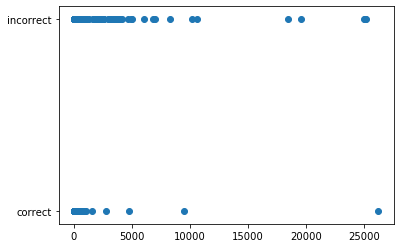

In [17]:
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(train_data['total_add_fare'], train_data['label'])
plt.show



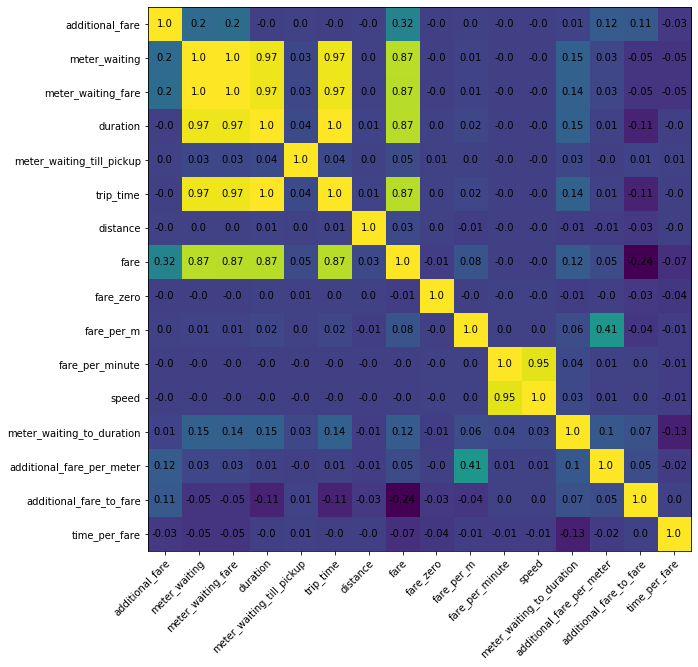

In [18]:
# get correlation matrix
corr = X.corr()
fig, ax = plt.subplots(figsize=(20, 10))
# create heatmap
im = ax.imshow(corr.values)

# set labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = ax.text(j, i, np.around(corr.iloc[i, j], decimals=2),
                       ha="center", va="center", color="black")

Hyperparameter tuning using cross validation for random forest classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# # Hyperparameter tuning using cross validation
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(random_grid)
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X, y)
# rf_random.best_params_
# output = {'n_estimators': 522,
#  'min_samples_split': 10,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': 40,
#  'bootstrap': False}

Hyper Parameter Optimization for xgboost

In [20]:
import xgboost

In [21]:
# from sklearn.model_selection import StratifiedKFold
# params={
#  "learning_rate"    : [ 0.04, 0.05, 0.7, 1.0 ] ,
#  "max_depth"        : [ 3, 5, 6, 8, 12],
#  "min_child_weight" : [ 1, 3, 5],
#  "subsample"        : [0.8, 0.9, 1.0],
#  "gamma"            : [ 0.0, 0.1, 0.2],
#  "colsample_bytree" : [ 0.7, 0.8, 1 ]
# }

# skf = StratifiedKFold(n_splits=2, shuffle = True, random_state = 1001)

# classifier=xgboost.XGBClassifier()
# random_search=GridSearchCV(estimator = classifier, param_grid = params, scoring='f1', n_jobs=4, cv=skf.split(X,y), verbose=3)
# random_search.fit(X,y)
# random_search.best_estimator_
# XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
#               importance_type='gain', interaction_constraints=None,
#               learning_rate=0.05, max_delta_step=0, max_depth=5,
#               min_child_weight=3, missing=nan, monotone_constraints=None,
#               n_estimators=100, n_jobs=0, num_parallel_tree=1,
#               objective='binary:logistic', random_state=0, reg_alpha=0,
#               reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
#               validate_parameters=False, verbosity=None)

In [22]:
# from sklearn.model_selection import StratifiedKFold
# params={
#  "learning_rate"    : [ 0.01, 0.02, 0.03, 0.04, 0.05, 0.1 ] ,
#  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15 ],
#  "min_child_weight" : [ 1, 3, 5, 7 ],
#  "subsample"        : [0.8, 0.9, 1.0],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#  "colsample_bytree" : [ 0.7, 0.8, 0.9, 1 ]
# }

# skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)

# classifier=xgboost.XGBClassifier()
# random_search=RandomizedSearchCV(estimator = classifier, param_distributions = params, n_iter=100, scoring='f1', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001)
# random_search.fit(X,y)
# random_search.best_estimator_
# # XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
# #               colsample_bynode=1, colsample_bytree=0.8, gamma=0.1, gpu_id=0,
# #               importance_type='gain', interaction_constraints=None,
# #               learning_rate=0.03, max_delta_step=0, max_depth=3,
# #               min_child_weight=7, missing=nan, monotone_constraints=None,
# #               n_estimators=1000, n_jobs=6, nthread=6, num_parallel_tree=1,
# #               objective='binary:hinge', random_state=0, reg_alpha=0,
# #               reg_lambda=1, scale_pos_weight=None, silent=True, subsample=0.8,
# #               tree_method='gpu_hist', validate_parameters=False,
# #               verbosity=None)

In [23]:
# params={
#  "learning_rate"    : [ 0.01, 0.02, 0.03, 0.04, 0.05, 0.1 ] ,
#  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15 ],
#  "min_child_weight" : [ 1, 3, 5, 7 ],
#  "subsample"        : [0.8, 0.9, 1.0],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#  "colsample_bytree" : [ 0.7, 0.8, 0.9, 1 ]
# }
# classifier=xgboost.XGBClassifier()
# random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=100,scoring='f1',n_jobs=-1,cv=10,verbose=3)
# random_search.fit(X,y)

# random_search.best_estimator_

Randomforest model

In [24]:
# # To improve accuracy, create a new Random Forest model which you will train on all training data

# model = RandomForestClassifier(n_estimators=500, max_depth=40, random_state=1, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', bootstrap=False)


Xgboost model

In [25]:
# model = xgboost.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.8, gamma=0.4, gpu_id=-1,
#               importance_type='gain', interaction_constraints=None,
#               learning_rate=0.02, max_delta_step=0, max_depth=12,
#               min_child_weight=7, missing=None, monotone_constraints=None,
#               n_estimators=100, n_jobs=0, num_parallel_tree=1,
#               objective='binary:logistic', random_state=0, reg_alpha=0,
#               reg_lambda=1, scale_pos_weight=1, subsample=0.9, tree_method=None,
#               validate_parameters=False, verbosity=None)
# 
# Model Performance
# Accuracy:0.958314
# F1 Score:0.859144

# model = xgboost.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
#               importance_type='gain', interaction_constraints=None,
#               learning_rate=0.06, max_delta_step=0, max_depth=8,
#               min_child_weight=3, missing=None, monotone_constraints=None,
#               n_estimators=200, n_jobs=0, num_parallel_tree=1,
#               objective='binary:logistic', random_state=0, reg_alpha=0,
#               reg_lambda=1, scale_pos_weight=1, subsample=0.9, tree_method=None,
#               validate_parameters=False, verbosity=None)

model = xgboost.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9, tree_method=None,
              validate_parameters=False, verbosity=None)

catboost

In [26]:
import catboost as cb

In [27]:
# params = {'depth':[3,1,2,6,4,5,7,8,9,10],
#           'iterations':[250,100,500,1000],
#           'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
#           'l2_leaf_reg':[3,1,5,10,100],
#           'border_count':[32,5,10,20,50,100,200]}

# classifier=cb.CatBoostClassifier()
# random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=100,scoring='f1',n_jobs=-1,random_state=42,cv=10,verbose=3)
# random_search.fit(X, y)
# random_search.best_params_

# {'learning_rate': 0.3,
#  'l2_leaf_reg': 100,
#  'iterations': 1000,
#  'depth': 7,
#  'border_count': 200}
# {'learning_rate': 0.01,
#  'l2_leaf_reg': 3,
#  'iterations': 250,
#  'depth': 10,
#  'border_count': 100}

In [28]:
# train classifier with tuned parameters    
# model = cb.CatBoostClassifier(learning_rate=0.01, l2_leaf_reg=3,iterations=250,depth=10,border_count=100)
# model = cb.CatBoostClassifier()
# Accuracy:0.958780
# F1 Score:0.863241

Cross validation of model and accuracy 

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
model.fit(train_X, train_y)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    f1score = f1_score(test_labels, predictions, average='macro')
    mse = mean_squared_error(test_labels, predictions)
    rmse = np.sqrt(mse)
    accuracy = accuracy_score(test_labels, predictions)
    print('Model Performance')
    print('Accuracy:%f'%accuracy)
    print('F1 Score:%f'%f1score)
#     print('Mean Squared Error : %.4f' % mse)
#     print('Root MSE : %.4f' % rmse)
    
evaluate(model, val_X, val_y)



Model Performance
Accuracy:0.956451
F1 Score:0.855141


[0]	validation_0-error:0.04401	validation_0-auc:0.92551	validation_1-error:0.04890	validation_1-auc:0.89679
[1]	validation_0-error:0.04332	validation_0-auc:0.92719	validation_1-error:0.04914	validation_1-auc:0.89761
[2]	validation_0-error:0.04200	validation_0-auc:0.93305	validation_1-error:0.04867	validation_1-auc:0.90253
[3]	validation_0-error:0.04207	validation_0-auc:0.93327	validation_1-error:0.04867	validation_1-auc:0.90261
[4]	validation_0-error:0.04192	validation_0-auc:0.93810	validation_1-error:0.04774	validation_1-auc:0.90529
[5]	validation_0-error:0.04192	validation_0-auc:0.93830	validation_1-error:0.04844	validation_1-auc:0.90491
[6]	validation_0-error:0.04192	validation_0-auc:0.94164	validation_1-error:0.04844	validation_1-auc:0.90537
[7]	validation_0-error:0.04215	validation_0-auc:0.94730	validation_1-error:0.04821	validation_1-auc:0.90800
[8]	validation_0-error:0.04223	validation_0-auc:0.94762	validation_1-error:0.04821	validation_1-auc:0.90898
[9]	validation_0-error:0.041

[76]	validation_0-error:0.03159	validation_0-auc:0.98099	validation_1-error:0.04332	validation_1-auc:0.93263
[77]	validation_0-error:0.03159	validation_0-auc:0.98125	validation_1-error:0.04332	validation_1-auc:0.93305
[78]	validation_0-error:0.03152	validation_0-auc:0.98144	validation_1-error:0.04308	validation_1-auc:0.93330
[79]	validation_0-error:0.03144	validation_0-auc:0.98164	validation_1-error:0.04262	validation_1-auc:0.93351
[80]	validation_0-error:0.03113	validation_0-auc:0.98174	validation_1-error:0.04308	validation_1-auc:0.93310
[81]	validation_0-error:0.03097	validation_0-auc:0.98199	validation_1-error:0.04332	validation_1-auc:0.93382
[82]	validation_0-error:0.03082	validation_0-auc:0.98222	validation_1-error:0.04332	validation_1-auc:0.93411
[83]	validation_0-error:0.03043	validation_0-auc:0.98240	validation_1-error:0.04332	validation_1-auc:0.93471
[84]	validation_0-error:0.03043	validation_0-auc:0.98264	validation_1-error:0.04308	validation_1-auc:0.93454
[85]	validation_0-e

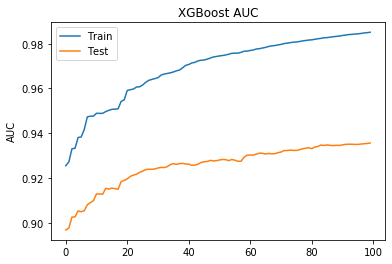

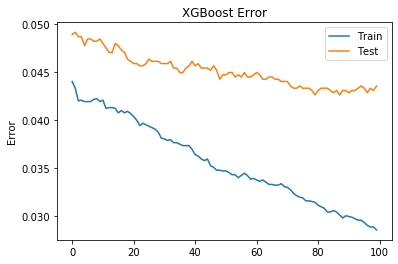

In [30]:
eval_metric = ['error','auc']
eval_set = [(train_X, train_y), (val_X, val_y)]
# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
%time model.fit(train_X, train_y, eval_set=eval_set, eval_metric=eval_metric, verbose=True)
 
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
 
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()
 
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()

Fit model and predict

In [31]:
#fit on all data from the training data
model.fit(X, y)

# make predictions which we will submit. 
predictions = model.predict(X_test)
# predictions = model.predict(X_test).astype('int')

Create output file

In [32]:
#create output
output = pd.DataFrame({'tripid': test_data.tripid, 'prediction': predictions})
output.to_csv('sample_submission.csv', index=False)